In [20]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import IPython.core.display as di

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.optimizers import  Adam


In [2]:
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
pd.options.mode.chained_assignment = None


In [3]:
# import dataset
df = pd.read_csv("20110810_preprocessing.txt")
df = df[["SrcAddr", "DstAddr", "label"]]
df["StartTime"] = df.index + 1 
df.head()

,SrcAddr,DstAddr,label,StartTime
0,212.50.71.179,147.32.84.229,0,1
1,84.13.246.132,147.32.84.229,0,2
2,217.163.21.35,147.32.86.194,0,3
3,83.3.77.74,147.32.85.5,0,4
4,74.89.223.204,147.32.84.229,0,5


> 先將資料取出成對IP並藉由StartTime排列。  
因為可能會有testing set出現training set沒出現過的IP的情況，所以我們打算將IP轉成一個timewindow裡面的degree，在之後做testing的時候就可以也轉化成degree去做代表。

### IP address ranking in time_window and sort by IP address

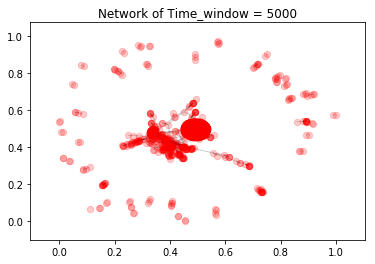

Count of IP in one time_window: 3514
Rank and Degree


,SrcAddr,degree,DstAddr,rank
0,212.50.71.179,1,212.50.71.179,1832.0
1,147.32.84.229,2893,147.32.84.229,1.0
2,84.13.246.132,1,84.13.246.132,1832.0
3,217.163.21.35,1,217.163.21.35,1832.0
4,147.32.86.194,9,147.32.86.194,16.0


In [4]:
# example for IP to rank

i = 0
time_window = 5000
df1 = df[((i)*time_window <= df.StartTime) & (df.StartTime < (i+1)*time_window)]
G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
nx.shortest_path(G)
nx.draw_networkx(G, node_size = 40, alpha = 0.2, with_labels = False)
plt.title("Network of Time_window = 5000")
plt.show()

### count degree
deg = pd.DataFrame(G.degree_iter())
deg.columns = ["SrcAddr", "degree"]
deg["DstAddr"] = deg.SrcAddr
print('Count of IP in one time_window:', deg.shape[0])

### to rank
deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                              na_option = 'keep', ascending = False, pct = False)
print("Rank and Degree")
deg.head()

In [5]:
def IP2deg(df, deg):
    df1 = df.merge(deg.drop(["degree","DstAddr"], axis=1), how = 'inner', on = "SrcAddr")
    df2 = df1.merge(deg.drop(["degree","SrcAddr"], axis=1), how = 'inner', on = "DstAddr")
    df2.columns = ["SrcAddr1","DstAddr1","label","StartTime","SrcAddr","DstAddr"]
    return df2

In [6]:
df_deg = IP2deg(df1, deg)
df_deg.head()

,SrcAddr1,DstAddr1,label,StartTime,SrcAddr,DstAddr
0,212.50.71.179,147.32.84.229,0,1,1832.0,1.0
1,84.13.246.132,147.32.84.229,0,2,1832.0,1.0
2,74.89.223.204,147.32.84.229,0,5,1832.0,1.0
3,66.169.184.207,147.32.84.229,0,6,1832.0,1.0
4,182.239.167.121,147.32.84.229,0,7,1832.0,1.0


### For Loop

In [7]:
time_window = 5000
size_of_window = int((df.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df3 = df[(i*time_window <= df.StartTime) & (df.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df3, 'SrcAddr', 'DstAddr', edge_attr = True)
    
    deg = pd.DataFrame(G.degree_iter(), columns = ["SrcAddr", "degree"])
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                                  na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df3, deg)
    y.append(df_deg)
    
df_ip = pd.concat(y, axis = 0).reset_index(drop = True)
print(df_ip.shape)


(2819999, 6)


In [9]:
### Sort by IP and StartTime
def sort_cw(df):
    df = df.sort_values(by = ["SrcAddr1","DstAddr1","StartTime"], ascending = True).reset_index(drop = True)
    df1 = df.drop(["SrcAddr1","DstAddr1","StartTime"], axis = 1)
    print("Size of dataset", df1.shape[0])
    cw0 = int(df1["label"].value_counts()[0]) / df1.shape[0]
    cw1 = int(df1["label"].value_counts()[1]) / df1.shape[0]
    print ("baseline :", cw0)
    return df1, cw0, cw1

df_ip, cw0, cw1 = sort_cw(df_ip)


Size of dataset 2819999
baseline : 0.9854748175442616


In [10]:
# split to train, validation, test
df_ip_ = df_ip[df_ip.index % 10 != 1].reset_index(drop = True)
test = df_ip[df_ip.index % 10 == 1].reset_index(drop = True)

train = df_ip_[df_ip_.index % 10 != 1].reset_index(drop = True)
val = df_ip_[df_ip_.index % 10 == 1].reset_index(drop = True)
print ("size of train :", train.shape[0])
print ("size of validation :", val.shape[0])
print ("size of test  :", test.shape[0])


size of train : 2284199
size of validation : 253800
size of test  : 282000


In [12]:
def reshape(df):
    seq_length = 1
    x = np.array(df[["SrcAddr", "DstAddr"]])
    X = np.reshape(x, (len(x), seq_length, 2))
    X = X / np.max(df.SrcAddr)
    
    y = np.array(df["label"])
    Y = np_utils.to_categorical(y)
    print ("number of botnet :", int(df["label"].value_counts()[1]))
    return X, Y

In [13]:
print("Reshape Training and Testing Dataset")
X_, y_ = reshape(df_ip_)
X_test, y_test = reshape(test)

X_train, y_train = reshape(train)
X_val, y_val = reshape(val)
print ("baseline :", sum(y_test[:,0])/y_test.shape[0])

Reshape Training and Testing Dataset
number of botnet : 36865
number of botnet : 4096
number of botnet : 33178
number of botnet : 3687
baseline : 0.985475177305


### Building rnn model

In [14]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(128, return_sequences = True,
               input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences = False, dropout=0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            67072     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 198,914
Trainable params: 198,914
Non-trainable params: 0
_________________________________________________________________


Train on 2284199 samples, validate on 253800 samples
Epoch 1/8
443s - loss: 0.0026 - acc: 0.9972 - val_loss: 0.2305 - val_acc: 0.9855
Epoch 2/8
425s - loss: 0.0031 - acc: 0.9977 - val_loss: 0.2342 - val_acc: 0.9855
Epoch 3/8
491s - loss: 0.0037 - acc: 0.9974 - val_loss: 0.2289 - val_acc: 0.9855
Epoch 4/8
392s - loss: 0.0028 - acc: 0.9977 - val_loss: 0.2319 - val_acc: 0.9855
Epoch 5/8
392s - loss: 0.0033 - acc: 0.9975 - val_loss: 0.2323 - val_acc: 0.9855
Epoch 6/8
392s - loss: 0.0031 - acc: 0.9976 - val_loss: 0.2327 - val_acc: 0.9855
Epoch 7/8
391s - loss: 0.0033 - acc: 0.9975 - val_loss: 0.2325 - val_acc: 0.9855
Epoch 8/8
545s - loss: 0.0032 - acc: 0.9975 - val_loss: 0.2342 - val_acc: 0.9855


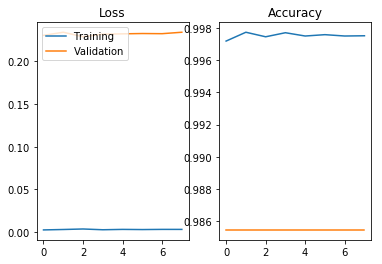

In [15]:
batch_size = 128
nb_epoch = 8 #200

history = model.fit(X_train, y_train,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 2,
                    shuffle = False, 
                    validation_data = (X_val, y_val),
                    class_weight = {0: cw0, 1: cw1})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()


In [16]:
score = model.evaluate(X_test, y_test, verbose = 2)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

Validation score: 0.234112595193
Validation accuracy: 0.985475177305


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Evaluation
def evaluation(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_ = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

    np.set_printoptions(precision=2)
    class_names = ["normal", "botnet"]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names,
                          title = 'Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names, normalize = True,
                          title = 'Normalized confusion matrix')
    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_true)/y_true.shape[0]))
    print("Precision   : %f" % precision_score(y_true, y_pred))
    print("Recall      : %f" % recall_score(y_true, y_pred))
    print("F1-Score    : %f" % f1_score(y_true, y_pred))
    print("AUC         : %f" % auc_)
    plt.show()


Confusion matrix, without normalization
[[277904      0]
 [  4096      0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]
------------------------------------
Baseline    : 0.985475
Precision   : 0.000000
Recall      : 0.000000
F1-Score    : 0.000000
AUC         : 0.500000


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


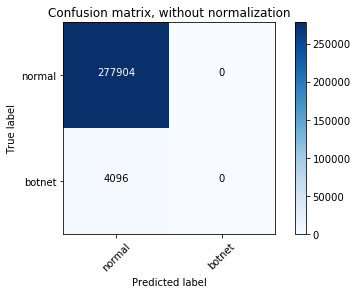

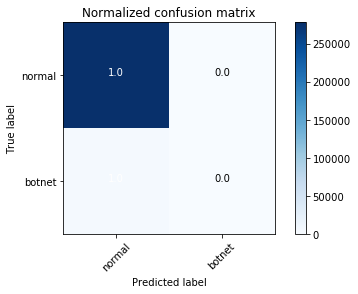

In [22]:
y_true = y_test[:,1]
y_pred = model.predict_classes(X_test, verbose = 2)
evaluation(y_true, y_pred)


In [23]:
model.fit(X_, y_, batch_size = batch_size, epochs = 16, verbose = 2,
          validation_data = (X_test, y_test), class_weight = {0: cw0, 1: cw1})


Train on 2537999 samples, validate on 282000 samples
Epoch 1/16
448s - loss: 0.0017 - acc: 0.9855 - val_loss: 0.1040 - val_acc: 0.9855
Epoch 2/16
433s - loss: 0.0016 - acc: 0.9855 - val_loss: 0.0875 - val_acc: 0.9855
Epoch 3/16
433s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0915 - val_acc: 0.9855
Epoch 4/16
434s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0854 - val_acc: 0.9855
Epoch 5/16
433s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0866 - val_acc: 0.9855
Epoch 6/16
434s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0892 - val_acc: 0.9855
Epoch 7/16
433s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0880 - val_acc: 0.9855
Epoch 8/16
433s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0870 - val_acc: 0.9855
Epoch 9/16
434s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0964 - val_acc: 0.9855
Epoch 10/16
434s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0959 - val_acc: 0.9855
Epoch 11/16
433s - loss: 0.0015 - acc: 0.9855 - val_loss: 0.0878 - val_acc: 0.9855
Epoch 12/16
433s - loss: 0.0015 - acc: 0.98

# Testing

In [24]:
df_11 = pd.read_csv("20110811_preprocessing.txt")
df_11 = df_11[["SrcAddr", "DstAddr", "label"]]
df_11["StartTime"] = df_11.index + 1 


In [25]:
time_window = 5000
size_of_window = int((df_11.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df1 = df_11[(i*time_window <= df_11.StartTime) & (df_11.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
    
    deg = pd.DataFrame(G.degree_iter(), columns = ["SrcAddr", "degree"])
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                                  na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df1, deg)
    y.append(df_deg)
    
appended_data_11 = pd.concat(y, axis = 0).reset_index(drop = True)
print(appended_data_11.shape)

# transfer to rank
appended_data_11, cw0, cw1 = sort_cw(appended_data_11)
test_X, test_y = reshape(appended_data_11)


(1804999, 6)
Size of dataset 1804999
baseline : 0.9883983315226214
number of botnet : 20941


In [26]:
score = model.evaluate(test_X, test_y, verbose = 2)
print('Test score:', score[0])  
print('Test accuracy:', score[1])

Test score: 0.0735594226992
Test accuracy: 0.988398331523


Confusion matrix, without normalization
[[1784058       0]
 [  20941       0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]
------------------------------------
Baseline    : 0.988398


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision   : 0.000000
Recall      : 0.000000
F1-Score    : 0.000000
AUC         : 0.500000


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


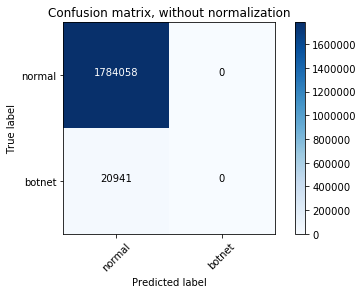

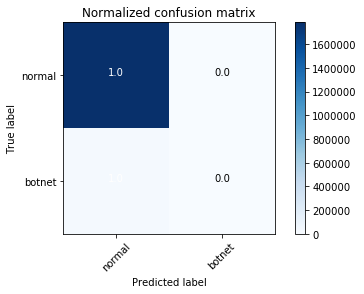

In [27]:
y_true = test_y[:,1]
y_pred = model.predict_classes(test_X, verbose = 2)
evaluation(y_true, y_pred)


### 0819

In [29]:
df_19 = pd.read_csv("20110819_preprocessing.txt")
df_19 = df_19[["SrcAddr", "DstAddr", "label"]]
df_19["StartTime"] = df_19.index + 1 


In [30]:
time_window = 5000
size_of_window = int((df_19.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df1 = df_19[(i*time_window <= df_19.StartTime) & (df_19.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
    
    deg = pd.DataFrame(G.degree_iter(), columns = ["SrcAddr", "degree"])
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                                  na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df1, deg)
    y.append(df_deg)
    
df_ip_19 = pd.concat(y, axis = 0).reset_index(drop = True)
print(df_ip_19.shape)

# transfer to rank
df_ip_19, cw0, cw1 = sort_cw(df_ip_19)
test_X, test_y = reshape(df_ip_19)


(324999, 6)
Size of dataset 324999
baseline : 0.993406133557334
number of botnet : 2143


In [31]:
score = model.evaluate(test_X, test_y, verbose = 2)
print('Test score:', score[0])  
print('Test accuracy:', score[1])

Test score: 0.0524318866394
Test accuracy: 0.993406133557


Confusion matrix, without normalization
[[322856      0]
 [  2143      0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]
------------------------------------
Baseline    : 0.993406
Precision   : 0.000000


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall      : 0.000000
F1-Score    : 0.000000
AUC         : 0.500000


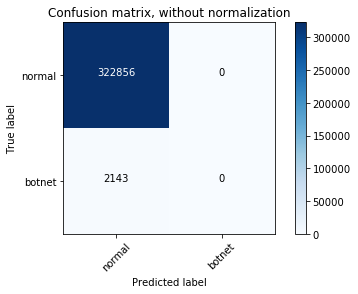

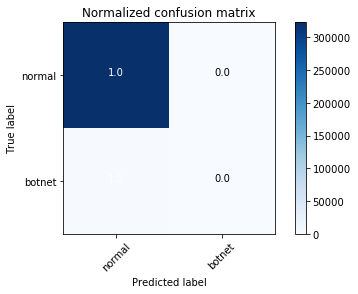

In [32]:
y_true = test_y[:,1]
y_pred = model.predict_classes(test_X, verbose = 2)
evaluation(y_true, y_pred)
